<a href="https://colab.research.google.com/github/agroimpacts/nmeo/blob/class%2Ff2023/materials/code/notebooks/planet_downloader_retiler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading and preparing PlanetScope data

This notebook provides instructions for working with selected samples to query the Planet API, download the necessary NICFI tiles by date, and then reprocess them into tiles defined by a different grid format.

## Requirements

### Files
You will need one input file:

- malawi_tiles_buf179.geojson

This file is the one you will select a subset from to collect NICFI tiles, and then retile them. You will have to select an area of 5X5 tiles first.


### Code
You will first have to install the clone our `maputil` repository from GitHub, which can be collected done by running the code below (first we mount Drive)

In [2]:
from google.colab import drive
root = '/content/gdrive'
drive.mount(root)

Mounted at /content/gdrive


#### Clone and/or update maputil

In [3]:
# from datetime import datetime as dt
repo_path = f"{root}/MyDrive/repos"
clone_path = 'https://github.com/agroimpacts/maputil.git'
if not os.path.exists(repo_path):
    print(f"Making {repo_path}")
    os.makedirs(repo_path, exist_ok=True)

if not os.path.exists(f"{repo_path}/maputil"):
    !git -C "{repo_path}" clone "{clone_path}"
else:
    !git -C "{repo_path}/maputil" pull

Already up to date.


### Install and import other necessary packages

Having cloned that repo, you need want to include the python modules that are contained in it within the import statements.

In [4]:
%%capture
%pip install affine
%pip install leafmap
%pip install localtileserver
%pip install leafmap
%pip install boto3
%pip install urllib3==2.0.3
%pip install rio-cogeo
#%pip install rioxarray

Restart the runtime to enable changes to take effect

In [4]:
import os
root = '/content/gdrive'
repo_path = f"{root}/MyDrive/repos"

# os.chdir(f"{repo_path}/maputil")
import sys
import importlib
from pathlib import Path
import affine
import pandas as pd
# import rioxarray as rxr
import leafmap.leafmap as leafmap
import localtileserver
import geopandas as gpd
import inspect
from rasterio.plot import show
# from botocore.utils import PROTOCOL_TLS

libpath = f"{repo_path}"
sys.path.insert(0, libpath)
import maputil
importlib.reload(maputil)
# importlib.reload(maputil.utils)
from maputil.maputil import *


## Set up the parameters to run the downloader

First, enter in the prompt below the path on Google Drive to a text file containing the Planet API key for your account. You can find that key by logging into your [Planet account](https://account.planet.com/) under the My Settings tab. Copy the key and save it into a simply text file (e.g. mykey.txt), which has only one line containing the key. This is safer than copying it into your notebook, where it might eventually become public.

In [ ]:
#@title #### Enter path to Planet key
x = input("Enter the path on Drive where your key is stored, "\
          "e.g. keys/mykey.txt: ")
key_path = f"{root}/MyDrive/{x}"

PLANET_API_KEY = open(key_path).read().strip()

The following parameters should be set for running the code.

- API_URL_KEY: Provided
- proj_path: The path where you want to place all files
- quad_dir: The place to download Planet basemap quads
- tile_dir: The place where tile clipped out of basemap quads will go
- temp_dir: The place where temporary files to be made during clipping out the tile go
- dst_width: The output width in pixels of the final PlanetScope tile (2368)
- dst_height: The output width in pixels of the final PlanetScope tile (2368)
- nbands: The number of output bands in the imagery (4)
- dst_crs: The output coordinate reference system ('EPSG=4326')
- tile_path: The path to the tile file provided for this exercise (malawi_tiles_full.geojson), which you can get [here](https://drive.google.com/file/d/1yTFp7IjvCVvPr9mBRD8L5PC20oGc_g5I/view?usp=sharing).

Change the paths below to match those on your system.

In [6]:
API_URL = 'https://api.planet.com/basemaps/v1/mosaics'

# change the dest_path to the one you want
proj_path = f"{root}/MyDrive/data/nmeo"  # main output path
os.makedirs(proj_path, exist_ok=True)

quad_dir = f"{proj_path}/quads"  # for downloaded NICFI quads
tile_dir = f"{proj_path}/tiles"  # for output tiles
temp_dir = f"{proj_path}/temp"   # temporary directory for intermediate outputs
log_dir = f"{proj_path}/logs"  # directory for log files

# output parameters for tiles
dst_width = 2358
dst_height = 2358
nbands = 4
dst_crs = 'EPSG:4326'

tile_path = f"{proj_path}/inputs/malawi_tiles_buf179.geojson"

### Read in tile file and select sub-area

Using the Malawi tiles

We just want to collect the month and year information from the samples file, and add it to the tiles file. We also want to convert the month and year data to a single variable, for querying the Planet API

In [7]:
tiles = gpd.read_file(tile_path)
tiles[tiles.columns[0:3]] = tiles[tiles.columns[0:3]].astype(int).astype(str)
tiles.head()

,tile,tile_col,tile_row,geometry
0,841570,1009,938,"POLYGON ((32.90452 -9.41447, 32.96348 -9.41447..."
1,841571,1010,938,"POLYGON ((32.95452 -9.41447, 33.01347 -9.41447..."
2,841572,1011,938,"POLYGON ((33.00453 -9.41447, 33.06347 -9.41447..."
3,841590,1009,939,"POLYGON ((32.90452 -9.46448, 32.96348 -9.46448..."
4,841591,1010,939,"POLYGON ((32.95452 -9.46448, 33.01347 -9.46448..."


View the tiles on the map, and then use the rectangle tool to select a small number of tiles (e.g. 10) anywhere in Malawi.  

In [ ]:
m = leafmap.Map()
m.add_basemap()
m.add_basemap("SATELLITE")
m.add_gdf(tiles, zoom_to_layer=True)
m

Save the polygon you draw to a geojson.

In [ ]:
m.save_draw_features(f"{proj_path}/inputs/aoi.geojson")

### Select the tiles using the AOI

In [11]:
aoi = gpd.read_file(f"{proj_path}/inputs/aoi.geojson")
tiles_aoi = tiles.sjoin(aoi)\
    .drop(columns="index_right")
tiles_aoi.shape

(20, 4)

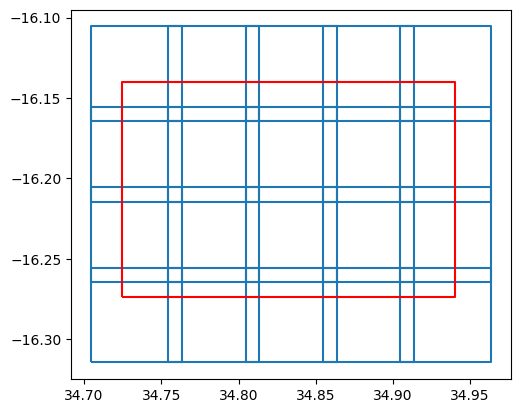

In [68]:
fig, ax = plt.subplots()
tiles_aoi.boundary.plot(ax=ax)
aoi.boundary.plot(ax=ax, color="red")
None

## Get the NICFI grid catalog for the tiles

### Query the catalog

Find the Planet basemap quads that intersect the selected tiles.
We first create a function for defining the correct dates of imagery, which vary in terms of their length of monthly coverage. The date period has to be exact when querying the API to get the images back from Planet.

In [13]:
def year_date(year, month):
    if (year < "2021") & (month < "06"):
        date = str(int(year)-1) + "-12_" + year + "-05"
    elif (year < "2020") & (month == "12"):
        date = year + "-12_" + str(int(year)+1) + "-05"
    elif (year == "2020") & (month == "12"):
        date = year + '-' + month
    elif (year < "2020") & ((month >= "06") & (month < "12")):
        date = year + "-06_" + year + "-11"
    elif (year == "2020") & ((month >= "06") & (month < "09")):
        date = year + "-06_" + year + "-08"
    else:
        date = year + '-' + month
    return(date)

Run the query, which will give you a list of GeoDataFrames containing the quad tile name, date, download URL, as well as the tile ID of the tiling grid we use here.

But first specify the year and month(s) of interest. In this example, we are using June, 2021.

In [14]:
date = year_date("2021", "06")

Then fetch the intersecting basemap quad grid.

In [ ]:
pdl = planet_downloader.PlanetDownloader()
quads_gdf, quads_url = pdl.get_basemap_grid(
    PLANET_API_KEY, API_URL, dates=[date],
    bbox=tiles_aoi.dissolve().iloc[0]["geometry"].bounds
)

In [16]:
quads_gdf.head()

,tile,date,geometry,file
0,1221-931,2021-06,"POLYGON ((34.80469 -16.13026, 34.80469 -15.961...",planet_medres_normalized_analytic_2021-06_mosa...
1,1222-931,2021-06,"POLYGON ((34.98047 -16.13026, 34.98047 -15.961...",planet_medres_normalized_analytic_2021-06_mosa...
2,1221-930,2021-06,"POLYGON ((34.80469 -16.29905, 34.80469 -16.130...",planet_medres_normalized_analytic_2021-06_mosa...
3,1222-930,2021-06,"POLYGON ((34.98047 -16.29905, 34.98047 -16.130...",planet_medres_normalized_analytic_2021-06_mosa...
4,1221-929,2021-06,"POLYGON ((34.80469 -16.46769, 34.80469 -16.299...",planet_medres_normalized_analytic_2021-06_mosa...


After iterating through the tile grid and querying the catalog, combine the results into a single GeoDataFrame, which you can save to a geojson, which lists the tiles you need to cover each grid.  

Now let's join the two catalogs, reorganize a bit and save to disk.

In [17]:
tiles_quads = tiles_aoi.sjoin(quads_gdf.rename(columns={"tile": "quad"}))\
    .drop(columns="index_right")\
    .iloc[:,[0,4,5,6,3]]

In [18]:
tiles_quads.to_file(
    Path(proj_path) / "tiles_quads.geojson", driver="GeoJSON"
)
# tiles_quads = gpd.read_file(
#     Path(proj_path) / "tiles_quads.geojson", driver="GeoJSON"
# )


## Download quads and retile

Once you have the catalog, you can now start to download quads and retile them. However, we are first going to test downloading just one quad. We will first set up some directories

In [19]:
# set up tile and temporary directory
if not os.path.isdir(tile_dir):
    os.makedirs(tile_dir)
if not os.path.isdir(quad_dir):
    os.makedirs(quad_dir)
if not os.path.isdir(temp_dir):
    os.makedirs(temp_dir)

### Download a single quad

Next, we will query the catalog we have created to see which tiles intersect just a single quad (they can intersect up to 4)

In [20]:
quad_counts = tiles_quads[["tile", "quad"]]\
    .groupby("tile")\
    .count()\
    .reset_index()

quad_counts.query("quad==1")

,tile,quad
5,927486,1
8,927489,1
9,927490,1
10,927506,1
13,927509,1
14,927510,1


Let's use the first one, 927486. We need to select that row from the DataFrame, build a download url, and then download it

In [22]:
# quad to download
tid = quad_counts.query("quad==1")['tile'].iloc[0]
tiles_quads_ss = tiles_quads[tiles_quads.tile==tid]
download_url = f"{quads_url}/<id>/full?api_key={PLANET_API_KEY}"

link = get_quad_download_url(download_url, tiles_quads_ss.quad.iloc[0])
filename = f"{quad_dir}/{tiles_quads_ss.file.iloc[0]}.tif"
download_tiles_helper(link, filename)

Downloaded: /content/gdrive/MyDrive/data/nmeo/quads/planet_medres_normalized_analytic_2021-06_mosaic_1221-930.tif


### Retile it

In [23]:
# Grab portion of quads that tile intersects and reproject/retile to that
transform = dst_transform(tiles_quads_ss)
dst_img = f"{tile_dir}/tile{tid}_{tiles_quads_ss['date'].iloc[0]}" +\
    f"_buf{int((dst_width-2000)/2)}.tif"
dst_cog = re.sub('.tif', '_cog.tif', dst_img)

filename = f'{quad_dir}/{tiles_quads_ss["file"].iloc[0]}.tif'

# # run retiler
if not os.path.isfile(dst_img) or not os.path.isfile(dst_cog):
    reproject_retile_image(
        filename, transform, dst_width, dst_height, nbands, dst_crs,
        dst_img, temp_dir, dst_dtype = np.int16, inmemory = False,
        cleanup=True
    )

### COG-ify it

In [24]:
# create COG from tile
cmd = ['rio', 'cogeo', 'create', '-b', '1,2,3,4', dst_img, dst_cog]
p = run(cmd, capture_output=True)
msg = p.stderr.decode().split('\n')
print(f'...{msg[-2]}')

cmd = ['rio', 'cogeo', 'validate', dst_cog]
p = run(cmd, capture_output = True)
msg = p.stdout.decode().split('\n')
print(f'...{msg[0]}')

...Writing output to: /content/gdrive/MyDrive/data/nmeo/tiles/tile927486_2021-06_buf179_cog.tif
.../content/gdrive/MyDrive/data/nmeo/tiles/tile927486_2021-06_buf179_cog.tif is a valid cloud optimized GeoTIFF


Let's have a look at it

In [129]:
m = leafmap.Map()
m.add_basemap()
m.add_basemap("SATELLITE")
# m.add_raster(filename)
m.add_raster(dst_cog, layer_name="Retiled Planet")
m.add_gdf(tiles_quads, zoom_to_layer=True, layer_name="Tile")
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

#### Download and retile multiple quads

For the case when one of our tiles overlaps The code below shows how to find which tiles overlap the largest number of different Planet quads.

In [40]:
quad_counts.query("quad==quad.max()")

,tile,quad
1,927467,4
2,927468,4
16,927527,4
17,927528,4


We'll use it in an updated version of the code above to download the quads

In [169]:
# Block #1
# download_url template and variable for output file names
filenames = []
download_url = f"{quads_url}/<id>/full?api_key={PLANET_API_KEY}"

# quad to download
tid = quad_counts.query("quad==quad.max()")['tile'].iloc[0]
tiles_quads_ss = tiles_quads[tiles_quads.tile==tid]
poly = tiles[tiles.tile==tid]

Since there is more than one quad to download, we will iterate over them in a loop

In [168]:
# Block # 2
# download each quad in a loop
for i, row in tiles_quads_ss.iterrows():
    print(i)
    link = get_quad_download_url(download_url, row['quad'])
    filename = f"{quad_dir}/{row['file']}.tif"
    filenames.append(filename)
    download_tiles_helper(link, filename)

3926
File already exists: /content/gdrive/MyDrive/data/nmeo/quads/planet_medres_normalized_analytic_2021-06_mosaic_1221-930.tif
3926
File already exists: /content/gdrive/MyDrive/data/nmeo/quads/planet_medres_normalized_analytic_2021-06_mosaic_1221-931.tif
3926
File already exists: /content/gdrive/MyDrive/data/nmeo/quads/planet_medres_normalized_analytic_2021-06_mosaic_1222-930.tif
3926
File already exists: /content/gdrive/MyDrive/data/nmeo/quads/planet_medres_normalized_analytic_2021-06_mosaic_1222-931.tif


We can use the code below to see how the tile boundary intersects the quad footprints

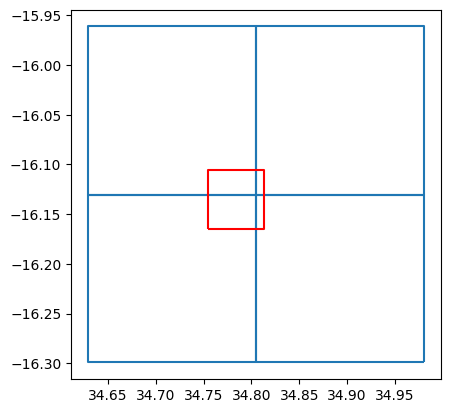

In [157]:
# make polygons out of the quad extents
polygons = []
for file in filenames:
    with rasterio.open(file) as src:
        bounds = src.bounds
        polygon = box(bounds.left, bounds.bottom, bounds.right, bounds.top)
        polygons.append(gpd.GeoDataFrame({'geometry': [polygon]}))

quad_polys = pd.concat(polygons)\
    .set_crs(src.crs)\
    .to_crs(4326)\

# plot the tile and quad boundaries
fig, ax = plt.subplots()
quad_polys.boundary.plot(ax=ax)
poly.boundary.plot(ax=ax, color="red")
None

Now let's make our tile out of the quads

In [167]:
# Block 3
transform = dst_transform(poly)

dst_img = f"{tile_dir}/tile{tid}_{row['date']}" +\
        f"_buf{int((dst_width-2000)/2)}.tif"
dst_cog = re.sub('.tif', '_cog.tif', dst_img)

# run retiler
if not os.path.isfile(dst_img) or not os.path.isfile(dst_cog):
    reproject_retile_image(
        filenames, transform, dst_width, dst_height, nbands, dst_crs,
        dst_img, temp_dir, dst_dtype = np.int16, inmemory = False,
        cleanup=True
    )

if not os.path.isfile(dst_cog):

    # create COG from tile
    cmd = ['rio', 'cogeo', 'create', '-b', '1,2,3,4', dst_img, dst_cog]
    p = run(cmd, capture_output=True)
    msg = p.stderr.decode().split('\n')
    print(f'...{msg[-2]}')

    cmd = ['rio', 'cogeo', 'validate', dst_cog]
    p = run(cmd, capture_output = True)
    msg = p.stdout.decode().split('\n')
    print(f'...{msg[0]}')

# clean up
if os.path.exists(dst_cog):
    if os.path.exists(dst_img):
        os.remove(dst_img)

..mosaicking 4 images
....creating temporary mosaick /content/gdrive/MyDrive/data/nmeo/temp/i5wn4fl0_mosaic.tif
..reprojecting, retiling tile927467_2021-06_buf179.tif
....removing temporary mosaick /content/gdrive/MyDrive/data/nmeo/tiles/tile927467_2021-06_buf179.tif
Retiling and reprojecting of /content/gdrive/MyDrive/data/nmeo/tiles/tile927467_2021-06_buf179.tif complete!


Let's look at it now

In [ ]:
# doesn't work for now
# m = leafmap.Map()
# m.add_basemap("SATELLITE")
# m.add_gdf(poly, zoom_to_layer=True, layer_name="Tiles")
# m.add_gdf(quad_polys, layer_name="Quads")
# m.add_raster(dst_cog, layer_name="Retiled Planet")
# m

In [ ]:
# use this instead
fig, ax = plt.subplots()
show(rasterio.open(dst_cog), ax=ax, adjust=True)
quad_polys.boundary.plot(ax=ax)
None

### Exercise

Process all the tiles in your `tiles_quads` GeoDataFrame, by combining and adapting the code from Blocks 1, 2, and 3 above.

In [ ]:
# Getting started
download_url = f"{quads_url}/<id>/full?api_key={PLANET_API_KEY}"

tids = list(tiles_quads.tile.unique())
for tid in tids:
    ## add code here
    filenames = []

    # quad to download
    tiles_quads_ss = tiles_quads[tiles_quads.tile==tid]

    # tile shape
    poly = tiles[tiles.tile==tid]

    # fill in the rest
